In [178]:
# ============================================================
# 1️⃣ Importaciones
# ============================================================
import pandas as pd
import numpy as np
import unicodedata
from ftfy import fix_text
from IPython.display import IFrame, display
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import folium
from folium import IFrame
import json
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

pd.set_option('display.max_rows', 100)
pd.set_option('future.no_silent_downcasting', True)

In [179]:
# ============================================================
# 2️⃣ Cargar dataset original
# ============================================================
ruta_dataset = "../data/raw/elecciones_municipios.csv"
dataset = pd.read_csv(ruta_dataset, encoding="latin1", low_memory=False)

print("Columnas originales:", dataset.columns.tolist())
print(dataset.head(3))

Columnas originales: ['annoh', 'corp', 'eleccion', 'codcirc', 'nomdepto', 'coddepto', 'nommun', 'codmpio', 'zona', 'nompuesto', 'puesto', 'nomparti', 'codparti', 'nomcandi', 'codcandi', 'votos', 'censo', 'rcd___id']
   annoh  corp   eleccion  codcirc   nomdepto  coddepto    nommun  codmpio  \
0   2019     3  AlcaldÃ­a        2  ANTIOQUIA         1  MEDELLIN        1   
1   2019     3  AlcaldÃ­a        2  ANTIOQUIA         1  MEDELLIN        1   
2   2019     3  AlcaldÃ­a        2  ANTIOQUIA         1  MEDELLIN        1   

     zona                    nompuesto  puesto  \
0  Urbano  SEC. ESC. LA ESPERANZA NO 2     1.0   
1  Urbano  SEC. ESC. LA ESPERANZA NO 2     1.0   
2  Urbano  SEC. ESC. LA ESPERANZA NO 2     1.0   

                                       nomparti  codparti  \
0                         PARTIDO ALIANZA VERDE         4   
1         PARTIDO POLO DEMOCRÃTICO ALTERNATIVO         9   
2  PARTIDO COLOMBIA HUMANA - UNIÃN PATRIÃTICA        10   

                     nomc

In [180]:
# ============================================================
# 3️⃣ Eliminar columnas irrelevantes y renombrar
# ============================================================
dataset = dataset.drop(columns=["corp","codcirc","coddepto","codmpio", "zona", "nompuesto", "puesto", "codcandi", "censo", "rcd___id"])
dataset.columns = ["anio", "eleccion", "departamento", "municipio", "partido_politico", "codigo_partido", "nombre_candidato", "votos"]

In [181]:
# ============================================================
# 4️⃣ Reparar texto antes de limpiar
# ============================================================
for col in ["departamento", "municipio", "eleccion", "partido_politico", "nombre_candidato"]:
    dataset[col] = dataset[col].astype(str).apply(fix_text)

# Función para limpiar texto
def limpiar_texto(texto):
    if pd.isna(texto):
        return ""
    texto = texto.lower().strip()
    texto = "".join(c for c in unicodedata.normalize("NFD", texto)
                    if unicodedata.category(c) != "Mn")
    texto = texto.replace("ñ", "n")
    return texto

In [182]:
# ============================================================
# 5️⃣ Aplicar limpieza de texto
# ============================================================
for col in ["departamento", "municipio", "eleccion", "partido_politico", "nombre_candidato"]:
    dataset[col] = dataset[col].apply(limpiar_texto)

print(dataset.head(3))

   anio  eleccion departamento municipio  \
0  2019  alcaldia    antioquia  medellin   
1  2019  alcaldia    antioquia  medellin   
2  2019  alcaldia    antioquia  medellin   

                             partido_politico  codigo_partido  \
0                       partido alianza verde               4   
1        partido polo democratico alternativo               9   
2  partido colombia humana - union patriotica              10   

             nombre_candidato  votos  
0                beatriz rave  13753  
1  victor javier correa velez   9670  
2         jairo herran vargas   2829  


In [183]:
# ============================================================
# 6️⃣ Revisar valores únicos
# ============================================================
columnas_texto = ["anio", "eleccion", "departamento", "municipio", "partido_politico"]

for col in columnas_texto:
    print(f"\n📌 Columna: {col}")
    valores_unicos = sorted(dataset[col].dropna().unique())
    print(f"Total valores únicos: {len(valores_unicos)}")
    print(valores_unicos[:50])



📌 Columna: anio
Total valores únicos: 9
[np.int64(2007), np.int64(2010), np.int64(2011), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2018), np.int64(2019), np.int64(2022)]

📌 Columna: eleccion
Total valores únicos: 14
['alcaldia', 'asamblea departamental', 'camara citrep', 'camara indigena', 'camara negritudes', 'camara territorial', 'concejo', 'consulta anticorrupcion', 'gobernacion', 'plebiscito por la paz', 'presidencia 1era vuelta', 'presidencia 2da vuelta', 'senado indigena', 'senado nacional']

📌 Columna: departamento
Total valores únicos: 35
['amazonas', 'antioquia', 'arauca', 'archipielago de san andres', 'atlantico', 'bogota', 'bolivar', 'boyaca', 'caldas', 'caqueta', 'casanare', 'cauca', 'cesar', 'choco', 'consulados', 'cordoba', 'cundinamarca', 'guainia', 'guaviare', 'huila', 'la guajira', 'magdalena', 'meta', 'narino', 'norte de santander', 'putumayo', 'quindio', 'risaralda', 'san andres', 'santander', 'sucre', 'tolima', 'valle del cauca', 'vaupes', 'vichada']

In [184]:
# ============================================================
# 7️⃣ Unificar, capitalizar y guardar dataset limpio
# ============================================================
dataset["departamento"] = dataset["departamento"].replace({
    "san andres": "archipielago de san andres"
})
dataset["departamento"] = dataset["departamento"].str.title()
dataset["municipio"] = dataset["municipio"].str.title()

ruta_salida = "../data/processed/elecciones_municipios_limpio.csv"
dataset.to_csv(ruta_salida, index=False, encoding="utf-8-sig")
print("✅ Dataset limpio guardado en:", ruta_salida)

✅ Dataset limpio guardado en: ../data/processed/elecciones_municipios_limpio.csv


In [185]:
# ============================================================
# 8️⃣ Normalizar nombres de partidos y seleccionar años clave
# ============================================================
years = [2007, 2011, 2015, 2019]
ds = dataset[dataset["anio"].isin(years)].copy()

def canon_partido(p):
    if not isinstance(p, str): return p
    s = p.lower()
    if "centro democr" in s: return "Centro Democrático"
    if "colombia humana" in s: return "Colombia Humana"
    if "union patriot" in s: return "Unión Patriótica"
    if "polo" in s: return "Polo Democrático"
    if "liberal" in s: return "Partido Liberal"
    if "conservador" in s: return "Partido Conservador"
    if "alianza verde" in s or "partido verde" in s: return "Partido Verde"
    if "cambio radical" in s: return "Cambio Radical"
    if "partido de la u" in s or "unidad nacional" in s: return "Partido de la U"
    return s.title()

ds["partido_canon"] = ds["partido_politico"].astype(str).apply(canon_partido)
ds["votos"] = pd.to_numeric(ds["votos"], errors="coerce").fillna(0).astype(int)

In [186]:
# ============================================================
# 9️⃣ Calcular los 100 partidos más votados
# ============================================================
df_alcaldias = ds[ds["eleccion"].str.contains("alcaldia", case=False, na=False)].copy()

votos_totales = (
    df_alcaldias.groupby("partido_canon")["votos"]
    .sum()
    .sort_values(ascending=False)
)

top100_partidos = votos_totales.head(100)

pd.set_option('display.max_rows', 100)
print("\n🏆 Top 100 partidos más votados en elecciones de alcaldía (2007–2019):\n")
print(top100_partidos)

ds_top100 = df_alcaldias[df_alcaldias["partido_canon"].isin(top100_partidos.index)].copy()



🏆 Top 100 partidos más votados en elecciones de alcaldía (2007–2019):

partido_canon
Partido Liberal                                           9410231
Partido de la U                                           7211920
Partido Conservador                                       6660515
Cambio Radical                                            6636248
Partido Verde                                             2999060
Centro Democrático                                        2994371
Polo Democrático                                          2031453
Voto En Blanco                                            1861811
Voto No Marcados                                          1603609
Votos Nulos                                               1502810
Coalicion Claudia Alcaldesa                               1109362
Partido Alianza Social Independiente                      1097273
Votos En Blanco                                           1077073
G.S.C. Bogota Para La Gente                             

In [187]:
# ============================================================
# 🔟 Clasificar partidos según ideología (diccionario completo)
# ============================================================
ideologias = {
    # 🟥 Izquierda
    "Polo Democrático": "Izquierda",
    "Colombia Humana": "Izquierda",
    "Unión Patriótica": "Izquierda",
    "Movimiento Alternativo Indigena Y Social": "Izquierda",
    "Movimiento Alternativo Indigena Y Social \"Mais\"": "Izquierda",
    "Progresistas": "Izquierda",
    "G.S.C Fuerza Ciudadana -Magdalena": "Izquierda",
    "Movimiento Politico Afrovides": "Izquierda",
    "Movimiento Alianza Social Afrocolombiana \"Asa\"": "Izquierda",
    "Movimiento Colombia Viva": "Izquierda",
    "Movimiento Alianza Social IndヘGena": "Izquierda",
    "Coalicion Claudia Alcaldesa": "Izquierda",

    # 🟨 Centro
    "Partido Liberal": "Centro",
    "Alianza Verde": "Centro",
    "Partido Verde": "Centro",
    "Partido Verde Opcion Centro": "Centro",
    "Partido De La U": "Centro",
    "Partido Social De Unidad Nacional": "Centro",
    "Partido Ada": "Centro",
    "Recuperemos Bogota": "Centro",
    "Bogota Adelante": "Centro",
    "Gina Parody Alcaldesa": "Centro",
    "Alcalde Guerrero": "Centro",
    "Cali Una Nueva Ciudad": "Centro",
    "Coalicion": "Centro",  # para coaliciones sin ideología clara

    # 🟦 Derecha
    "Centro Democrático": "Derecha",
    "Partido Conservador": "Derecha",
    "Cambio Radical": "Derecha",
    "Partido Opcion Ciudadana": "Derecha",
    "Partido Convergencia Ciudadana": "Derecha",
    "Movimiento De Inclusion Y Oportunidades": "Derecha",
    "Partido De Integracion Nacional": "Derecha",
    "Partido Colombia Democratica": "Derecha",
    "Partido Colombia Justa Libres": "Derecha",
    "Movimiento \"Mira\"": "Derecha",
    "Partido Politico Mira": "Derecha",
    "Movimiento \" Mira \"": "Derecha",
    "Coal. Partido Asi - Partido Colombia Justa Libres": "Derecha",
    "Compromiso Por Antioquia": "Derecha",
    "Creemos": "Derecha",
    "Una Antioquia Nueva": "Derecha",
}

ds_top100["ideologia"] = ds_top100["partido_canon"].map(ideologias).fillna("Centro")


In [188]:
# ============================================================
# 11️⃣ Calcular victorias por alcaldías y gobernaciones
# ============================================================
alcaldia = ds_top100[ds_top100["eleccion"].str.contains("alcaldia|alcaldía", na=False)]
gobernacion = ds_top100[ds_top100["eleccion"].str.contains("gobernacion|gobernación", na=False)]

# Ganadores por año y lugar
ganadores_alcaldia = alcaldia.loc[alcaldia.groupby(["anio", "departamento", "municipio"])["votos"].idxmax()]
ganadores_gob = gobernacion.loc[gobernacion.groupby(["anio", "departamento"])["votos"].idxmax()]

# Contar victorias por ideología
victorias_alcaldia = ganadores_alcaldia.groupby(["anio", "ideologia"]).size().unstack(fill_value=0)
victorias_gob = ganadores_gob.groupby(["anio", "ideologia"]).size().unstack(fill_value=0)

In [189]:
# ============================================================
# 12️⃣ Calcular votos totales por ideología
# ============================================================
votos_por_ideologia = ds_top100.groupby(["anio", "ideologia"])["votos"].sum().unstack(fill_value=0)

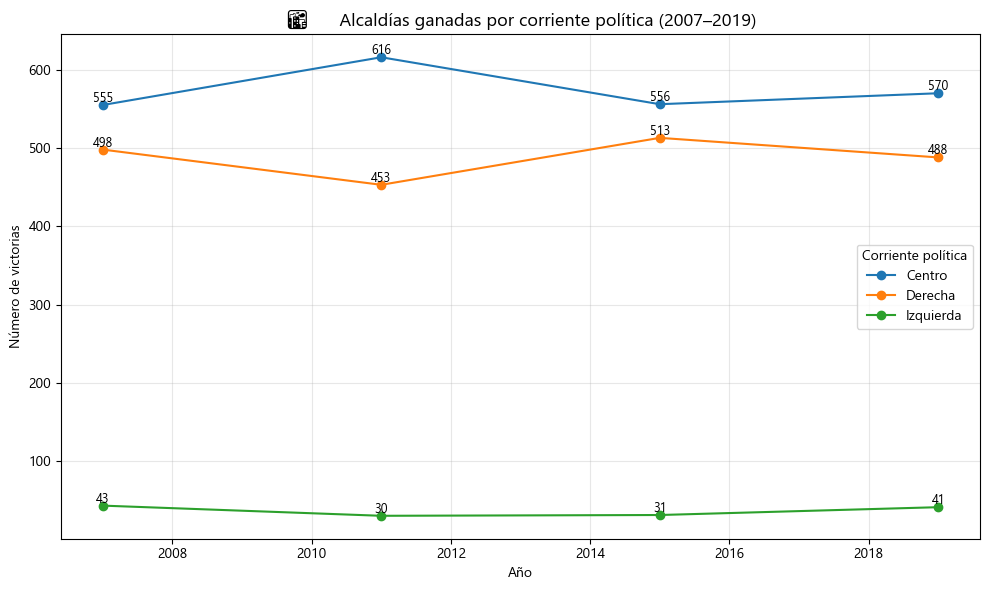

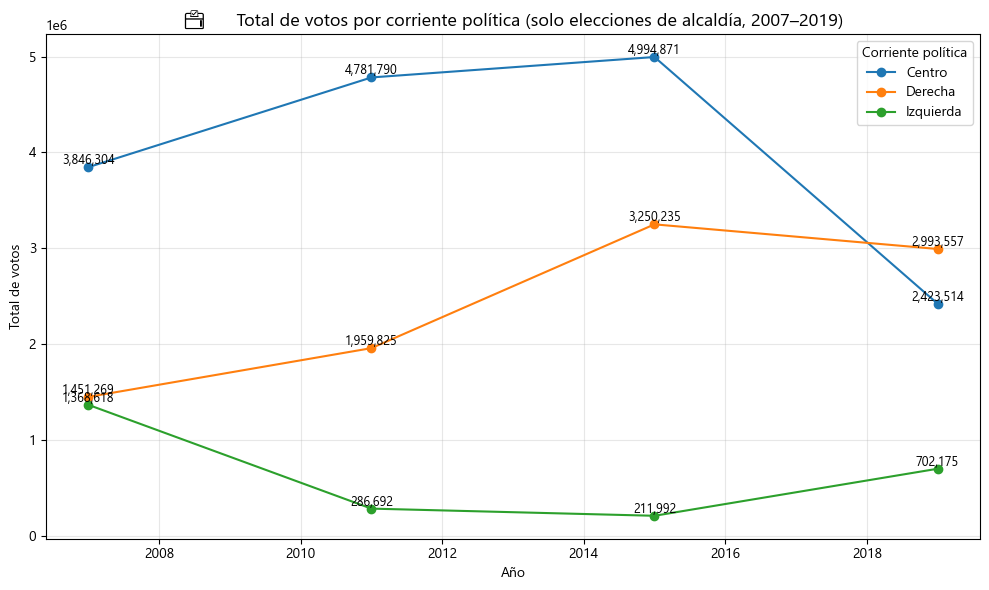


✅ Gráficos generados con etiquetas numéricas y formato mejorado.


In [190]:
# ============================================================
# 13️⃣ Graficar resultados (versión mejorada con etiquetas y emojis)
# ============================================================
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # Soporte para emojis en Windows
plt.rcParams['axes.unicode_minus'] = False # Evita error de signos en ejes


# 🏙️ Alcaldías ganadas
plt.figure(figsize=(10,6))
for col in victorias_alcaldia.columns:
    plt.plot(victorias_alcaldia.index, victorias_alcaldia[col], marker='o', label=col)
    # Mostrar etiquetas numéricas
    for x, y in zip(victorias_alcaldia.index, victorias_alcaldia[col]):
        plt.text(x, y, f"{y:,}", fontsize=9, ha='center', va='bottom')
plt.title("🏙️ Alcaldías ganadas por corriente política (2007–2019)", fontsize=13, weight='bold')
plt.xlabel("Año")
plt.ylabel("Número de victorias")
plt.legend(title="Corriente política")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

ds_top100["ideologia"] = ds_top100["partido_canon"].map(ideologia_map)

votos_por_ideologia = (
    ds_top100.groupby(["anio", "ideologia"])["votos"]
    .sum()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10,6))
for col in votos_por_ideologia.columns:
    plt.plot(votos_por_ideologia.index, votos_por_ideologia[col],
             marker='o', label=col)
    # Etiquetas numéricas con formato miles
    for x, y in zip(votos_por_ideologia.index, votos_por_ideologia[col]):
        plt.text(x, y, f"{y:,.0f}", fontsize=9, ha='center', va='bottom')

plt.title("🗳️ Total de votos por corriente política (solo elecciones de alcaldía, 2007–2019)",
          fontsize=13, weight='bold')
plt.xlabel("Año")
plt.ylabel("Total de votos")
plt.legend(title="Corriente política")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Gráficos generados con etiquetas numéricas y formato mejorado.")

In [191]:
# ============================================================
# 1️⃣ Filtrar elecciones presidenciales (1ª y 2ª vuelta)
# ============================================================
df_presidencia = dataset[
    dataset["eleccion"].str.contains("presidencia", case=False, na=False)
].copy()

print(f"✅ Registros filtrados: {len(df_presidencia):,}")

# ============================================================
# 2️⃣ Verificar los tipos de elecciones únicos
# ============================================================
print("\n📊 Tipos de elecciones presidenciales registradas:\n")
print(df_presidencia["eleccion"].value_counts())

# ============================================================
# 3️⃣ Listar los partidos únicos y su número de candidatos
# ============================================================
partidos_presidenciales = (
    df_presidencia.groupby("partido_politico")["nombre_candidato"]
    .nunique()
    .sort_values(ascending=False)
)

print("\n🏛️ Partidos con candidatos presidenciales (ordenados por número de candidatos únicos):\n")
print(partidos_presidenciales)
print(f"\nTotal partidos que han tenido candidato presidencial: {partidos_presidenciales.shape[0]}")


✅ Registros filtrados: 71,540

📊 Tipos de elecciones presidenciales registradas:

eleccion
presidencia 1era vuelta    48234
presidencia 2da vuelta     23306
Name: count, dtype: int64

🏛️ Partidos con candidatos presidenciales (ordenados por número de candidatos únicos):

partido_politico
votos en blanco                                                            2
votos nulos                                                                2
partido conservador colombiano                                             2
votos no marcados                                                          2
partido verde                                                              2
alianza social afrocolombiana "asa"                                        1
centro democratico mano firme corazon grande                               1
coalicion #mejor vargas lleras ante todo colombia                          1
coalicion centro esperanza                                                 1
coalicion equipo p

In [194]:
# ============================================================
# 2️⃣ Crear diccionario de ideologías para partidos presidenciales
# ============================================================
ideologia_presidenciales = {
    # 🟥 Izquierda
    "coalicion pacto historico": "Izquierda",
    "coalicion petro presidente": "Izquierda",
    "polo democratico alternativo": "Izquierda",
    "polo democratico alternativo pda union patriotica up": "Izquierda",
    "union patriotica": "Izquierda",
    "partido verde oxigeno": "Izquierda",
    "movimiento la voz de la consciencia": "Izquierda",
    "coalicion colombia": "Izquierda",
    "partido verde": "Izquierda",
    "partido alianza verde": "Izquierda",

    # 🟩 Centro
    "coalicion centro esperanza": "Centro",
    "partido somos": "Centro",
    "movimiento politico todos somos colombia": "Centro",
    "coalicion par. liberal colombiano par. alianza social independiente asi": "Centro",
    "partido liberal colombiano": "Centro",
    "liga de gobernantes anticorrupcion": "Centro",

    # 🟦 Derecha
    "centro democratico mano firme corazon grande": "Derecha",
    "colombia piensa en grande": "Derecha",
    "partido centro democratico": "Derecha",
    "partido conservador colombiano": "Derecha",
    "partido cambio radical": "Derecha",
    "partido social de unidad nacional": "Derecha",
    "coalicion equipo por colombia": "Derecha",
    "coalicion #mejor vargas lleras ante todo colombia": "Derecha",
    "colombia justa libres": "Derecha",
    "partido movimiento de salvacion nacional": "Derecha",
    "alianza social afrocolombiana asa": "Derecha",
    "movimiento apertura liberal": "Derecha",
    "unidad nacional": "Derecha",

    # Nulos, en blanco y no marcados
    "votos en blanco": "Nulos_Blanco",
    "votos nulos": "Nulos_Blanco",
    "votos no marcados": "Nulos_Blanco",
    "votos blancos": "Nulos_Blanco",
    "voto en blanco": "Nulos_Blanco",
    "voto no marcados": "Nulos_Blanco",
}

# Asignar ideología
df_presidencia["ideologia"] = df_presidencia["partido_politico"].map(ideologia_presidenciales).fillna("Otros")

# Verificar conteo
print("\n📊 Distribución de ideologías:")
print(df_presidencia["ideologia"].value_counts())



📊 Distribución de ideologías:
ideologia
Nulos_Blanco    27672
Derecha         19616
Izquierda       13934
Centro           8152
Otros            2166
Name: count, dtype: int64


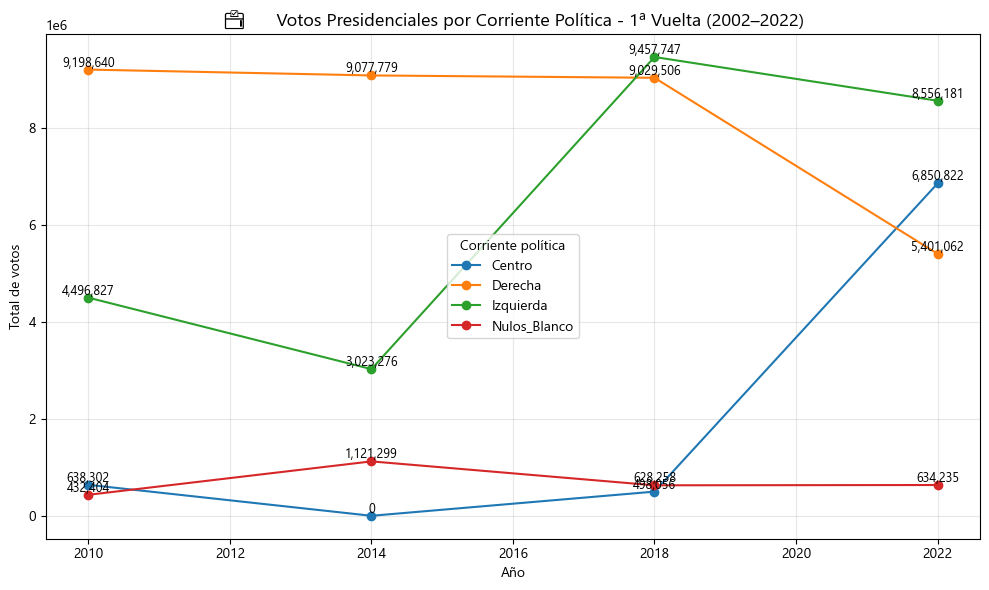

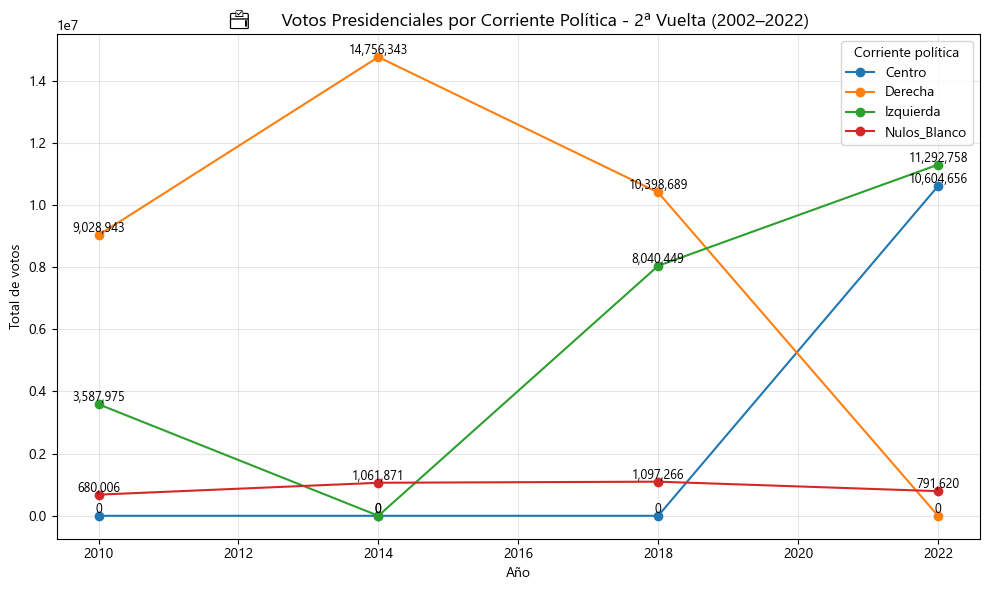

In [217]:
# ============================================================
# 3️⃣ Evolución de votos presidenciales por corriente política
# ============================================================

# Filtrar solo elecciones presidenciales con ideología asignada
df_presidencia_filtrado = df_presidencia[
    df_presidencia["ideologia"].isin(["Izquierda", "Centro", "Derecha", "Nulos_Blanco"])
]

# =============================
# 🗳️ 1️⃣ Primera vuelta
# =============================
df_presidencia_1v = df_presidencia_filtrado[
    df_presidencia_filtrado["eleccion"].str.contains("1era", case=False, na=False)
]

votos_presidenciales_1v = (
    df_presidencia_1v.groupby(["anio", "ideologia"])["votos"]
    .sum()
    .unstack(fill_value=0)
)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for col in votos_presidenciales_1v.columns:
    plt.plot(votos_presidenciales_1v.index, votos_presidenciales_1v[col], marker='o', label=col)
    for x, y in zip(votos_presidenciales_1v.index, votos_presidenciales_1v[col]):
        plt.text(x, y, f"{y:,.0f}", fontsize=9, ha='center', va='bottom')

plt.title("🗳️ Votos Presidenciales por Corriente Política - 1ª Vuelta (2002–2022)", fontsize=13, weight='bold')
plt.xlabel("Año")
plt.ylabel("Total de votos")
plt.legend(title="Corriente política")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# =============================
# 🗳️ 2️⃣ Segunda vuelta
# =============================
df_presidencia_2v = df_presidencia_filtrado[
    df_presidencia_filtrado["eleccion"].str.contains("2da", case=False, na=False)
]

votos_presidenciales_2v = (
    df_presidencia_2v.groupby(["anio", "ideologia"])["votos"]
    .sum()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10,6))
for col in votos_presidenciales_2v.columns:
    plt.plot(votos_presidenciales_2v.index, votos_presidenciales_2v[col], marker='o', label=col)
    for x, y in zip(votos_presidenciales_2v.index, votos_presidenciales_2v[col]):
        plt.text(x, y, f"{y:,.0f}", fontsize=9, ha='center', va='bottom')

plt.title("🗳️ Votos Presidenciales por Corriente Política - 2ª Vuelta (2002–2022)", fontsize=13, weight='bold')
plt.xlabel("Año")
plt.ylabel("Total de votos")
plt.legend(title="Corriente política")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [221]:
# --- función de limpieza con uppercase ---
def limpiar_texto_upper(texto):
    if pd.isna(texto):
        return ""
    texto = str(texto).strip().lower()
    texto = "".join(
        c for c in unicodedata.normalize("NFD", texto)
        if unicodedata.category(c) != "Mn"
    )
    return texto.upper()

# --- cargar shapefile y preparar ---
geo_path = "../mapas/geoBoundaries-COL-ADM1.geojson"
departamentos = gpd.read_file(geo_path)
departamentos["shapeName"] = departamentos["shapeName"].apply(limpiar_texto_upper)

# --- filtrar datos (presidencia 1ª vuelta 2022) ---
df_presidencia_1v = dataset[
    (dataset["anio"] == 2022) &
    (dataset["eleccion"].str.contains("presidencia 1era vuelta", case=False, na=False))
].copy()

# limpiar y normalizar departamentos
df_presidencia_1v["departamento"] = df_presidencia_1v["departamento"].apply(limpiar_texto_upper)

# equivalencias especiales
map_deptos = {
    "BOGOTA": "BOGOTA CAPITAL DISTRICT",
    "ARCHIPIELAGO DE SAN ANDRES": "ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA",
    "CONSULADOS": None  # no existe en shapefile
}
df_presidencia_1v["departamento"] = df_presidencia_1v["departamento"].replace(map_deptos)

# mapear ideología
df_presidencia_1v["ideologia"] = df_presidencia_1v["partido_politico"].map(ideologia_presidenciales)

# --- votos por departamento e ideología ---
agg = (
    df_presidencia_1v.groupby(["departamento", "ideologia"])["votos"]
    .sum()
    .reset_index()
)

# --- pivotear para tener columnas por ideología ---
pivot = agg.pivot(index="departamento", columns="ideologia", values="votos").fillna(0).astype(int).reset_index()

# --- unir con shapefile ---
geo_merged = departamentos.merge(pivot, left_on="shapeName", right_on="departamento", how="left")

# --- colores pastel/menos vivos ---
colores_corriente = {
    "Derecha": "#9ecae1",      # azul pastel
    "Centro": "#a1d99b",       # verde pastel
    "Izquierda": "#fcae91",    # rojo coral suave
    "Nulos_Blanco": "#cbc9e2", # lila claro
    "Sin datos": "#f7f7f7"     # gris muy claro
}

# --- GeoJson con popup en lugar de solo tooltip ---
gj = folium.GeoJson(
    data=geo_merged.to_json(),
    name="Corriente dominante",
    style_function=lambda feature: {
        "fillColor": colores_corriente.get(
            max(
                ["Derecha","Centro","Izquierda","Nulos_Blanco"],
                key=lambda k: feature["properties"].get(k,0)
            ),
            "#cccccc"
        ),
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["shapeName","Derecha","Centro","Izquierda","Nulos_Blanco"],
        aliases=["Departamento","Derecha","Centro","Izquierda","Nulos/Blanco"],
        localize=True
    )
).add_to(m)

# --- añadir leyenda con colores suaves ---
legend_html = """
<div style="
position: fixed;
bottom: 50px; left: 50px; width: 230px; height: 160px;
background-color: white; border:2px solid grey; z-index:9999; font-size:14px;padding:8px;
">
<b>Corriente dominante - Presidencia 1ª vuelta (2022)</b><br>
&nbsp;<i style="background:#9ecae1;width:12px;height:12px;display:inline-block;margin-right:8px;"></i> Derecha<br>
&nbsp;<i style="background:#a1d99b;width:12px;height:12px;display:inline-block;margin-right:8px;"></i> Centro<br>
&nbsp;<i style="background:#fcae91;width:12px;height:12px;display:inline-block;margin-right:8px;"></i> Izquierda<br>
&nbsp;<i style="background:#cbc9e2;width:12px;height:12px;display:inline-block;margin-right:8px;"></i> Nulos / Blanco<br>
&nbsp;<i style="background:#f7f7f7;width:12px;height:12px;display:inline-block;margin-right:8px;border:1px solid #ccc;"></i> Sin datos<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- guardar y mostrar ---
ruta_mapa = "../mapas/mapa_corrientes_presidencia_1v_2022.html"
m.save(ruta_mapa)
print("✅ Mapa guardado en:", ruta_mapa)

display(IFrame(ruta_mapa, width="100%", height=600))


✅ Mapa guardado en: ../mapas/mapa_corrientes_presidencia_1v_2022.html
